#Library Imports: 

In [81]:
import torch 
import numpy as np 
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Study of Linear Conduction (Heat): 

given two rods of length $\left(l=1\right)$ and conductivities $D_1$ and $D_2$ we need to find the temperature distribution inside the rods $U_1$ and $U_2$ respectively. 

##Proposed Algorithm: 




```
1.generate the boundary conditions at x=0, 1, 2. 
2.generate the system response at the boundaries.
3.generate the collocation points for each rod. 
4.generate the corresponding residuals for each. 
5.define two networks for u1 and u2 respectively.
6.define the residual to be (d_i * u''_i - 0). 

for epoch in range epochs: 
  u1bc = net1(x1bc)
  u2bc = net2(x2bc) 

  boundary_loss = mse(u1bc, 0)+mse(u2bc, 100) + (loss for x=1 conditions)
  residual_loss = mse(residual(net1(x1), 0)) + mse(residual(net2(x2), 0))

  loss = residual_loss + boundary_loss
  loss.backpropagate()
  optimise the params. 



```





###training data generation: 

In [82]:
x_bc_1 = np.zeros((10, 1))
x_bc_2 = 2*np.ones((10, 1))

u_bc_1 =  np.zeros((10, 1))
u_bc_2 = 1e2*np.ones((10, 1))

x_coll_1 = np.sort(np.random.uniform(0, 1, size=(500, 1)))
x_coll_2 = np.sort(np.random.uniform(1, 2, size=(500, 1)))

residuals_1 = np.zeros((500, 1))
residuals_2 = np.zeros((500, 1))

###network architecture: 

In [83]:
class net(nn.Module):
  def __init__(self, lb, ub):
    super(net, self).__init__()
    self.hidden_layer1 = nn.Linear(1,250)

    self.hidden_layer2 = nn.Linear(250,250)
    self.hidden_layer3 = nn.Linear(250,250)
    self.hidden_layer4 = nn.Linear(250,250)
    self.hidden_layer5 = nn.Linear(250,250)
    
    # self.dropout1 = nn.Dropout(0.1)
    # self.dropout2 = nn.Dropout(0.1)
    # self.dropout3 = nn.Dropout(0.1)
    # self.dropout4 = nn.Dropout(0.1)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.relu3 = nn.ReLU()
    self.relu4 = nn.ReLU()
    self.relu5 = nn.ReLU()
    self.relu6 = nn.ReLU()

    self.lrelu1 = nn.LeakyReLU(0.9)
    self.lrelu1 = nn.LeakyReLU(0.9)
    

    self.output_layer = nn.Linear(250,1)
    self.lb = lb
    self.ub = ub 

  def forward(self, x):
    inputs = (2*(self.ub-self.lb))*x-((self.lb+self.ub)/self.ub-self.lb)*100

    layer1_out = self.hidden_layer1(inputs)
    layer1_out = self.relu1(layer1_out)
    # layer1_out = self.dropout1(layer1_out)
    layer2_out = self.hidden_layer2(layer1_out)
    layer2_out = self.relu2(layer2_out)
    # layer2_out = self.dropout2(layer1_out)
    layer3_out = self.hidden_layer3(layer2_out)
    layer4_out = self.hidden_layer4(layer3_out)
    layer4_out = self.lrelu1(layer4_out)
    layer5_out = self.hidden_layer5(layer4_out)
    layer5_out = self.lrelu1(layer5_out)
    # layer5_out = self.dropout3(layer5_out)
    # layer6_out = self.hidden_layer6(layer5_out)
    # layer6_out = self.relu3(layer6_out)
    # layer7_out = self.hidden_layer7(layer6_out)
    # layer7_out = self.dropout4(layer7_out)
    # layer7_out = self.relu4(layer7_out)
    # layer8_out = self.hidden_layer8(layer7_out)
    # layer8_out = self.relu5(layer8_out)
    # layer9_out = self.hidden_layer9(layer8_out)
    # layer9_out = self.relu6(layer9_out)
    

    output = self.output_layer(layer5_out) 
    return output

In [84]:
net1 = net(0, 1)
net2 = net(1, 2)

net1 = net1.to(device)
net2 = net2.to(device)

mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(net1.parameters())+ list(net2.parameters()))

### defining the residual:

In [85]:
def residual_func(x, net, d):
  u = net(x)
  d_times_u_x = d*torch.autograd.grad(u.sum(), x, create_graph=True)[0]
  d_times_u_xx = torch.autograd.grad(d_times_u_x.sum(), x, create_graph=True)[0]

  ode = d_times_u_xx
  return ode

###training loop: 

In [86]:
import sys 

x_bc_3 = np.ones((100, 1))
u_bc_3 = np.zeros((100, 1))

iterations = 10000
d1 = 10.0
d2 = 0.10

l = 1e40

for epoch in range(iterations):
  optimizer.zero_grad()

  pt_x_bc_1 = Variable(torch.from_numpy(x_bc_1).float(), requires_grad=False).to(device)
  pt_x_bc_2 = Variable(torch.from_numpy(x_bc_2).float(), requires_grad=False).to(device)
  pt_u_bc_1 = Variable(torch.from_numpy(u_bc_1).float(), requires_grad=False).to(device)
  pt_u_bc_2 = Variable(torch.from_numpy(u_bc_2).float(), requires_grad=False).to(device)

  pt_x_bc_3 = Variable(torch.from_numpy(x_bc_3).float(), requires_grad=True).to(device)
  pt_u_bc_3 = Variable(torch.from_numpy(u_bc_3).float(), requires_grad=False).to(device)

  net_bc_out_1 = net1(pt_x_bc_1)
  net_bc_out_2 = net2(pt_x_bc_2)

  net_bc_out_11 = net1(pt_x_bc_3)
  net_bc_out_22 = net2(pt_x_bc_3)

  net_bc_out_111 = d1*torch.autograd.grad(net_bc_out_11.sum(), pt_x_bc_3, create_graph=True)[0]
  net_bc_out_222 = d2*torch.autograd.grad(net_bc_out_22.sum(), pt_x_bc_3, create_graph=True)[0]

  mse_bc = 1e8*mse(net_bc_out_1, pt_u_bc_1)+1e8*mse(net_bc_out_2, pt_u_bc_2)+1e8*(mse(net_bc_out_11-net_bc_out_22, pt_u_bc_3))+1*(mse(net_bc_out_111-net_bc_out_222, pt_u_bc_3))

  
  pt_x_coll_1 = Variable(torch.from_numpy(x_coll_1).float(), requires_grad=True).to(device)
  pt_x_coll_2 = Variable(torch.from_numpy(x_coll_2).float(), requires_grad=True).to(device)
  
  pt_r_coll_1 = Variable(torch.from_numpy(residuals_1).float(), requires_grad=False).to(device)
  pt_r_coll_2 = Variable(torch.from_numpy(residuals_2).float(), requires_grad=False).to(device)

  r1 = residual_func(pt_x_coll_1, net1, d1)
  r2 = residual_func(pt_x_coll_2, net2, d2)
  mse_r = 1e4*mse(r1, pt_r_coll_1)+1e2*mse(r2, pt_r_coll_2)

  loss = (1*mse_r)+(1*mse_bc)

  if loss.item()<l:
    torch.save(net1, "net1.pth")
    torch.save(net2, "net2.pth")
    l = loss.item()

  loss.backward()
  optimizer.step()

  if ((epoch+1)%1000 == 0):
    with torch.autograd.no_grad():
      print(f"{epoch+1}: Loss = {loss.data:10}")

1000: Loss = 332923043840.0
2000: Loss = 347596685312.0
3000: Loss = 210766921728.0
4000: Loss = 4867447808.0
5000: Loss = 1488280960.0
6000: Loss = 293096.96875
7000: Loss = 82.99566650390625
8000: Loss = 82.98518371582031
9000: Loss = 82.98518371582031
10000: Loss = 82.98518371582031


###visualising the results: 

In [87]:
net1 = torch.load('net1.pth')
net2 = torch.load('net2.pth')

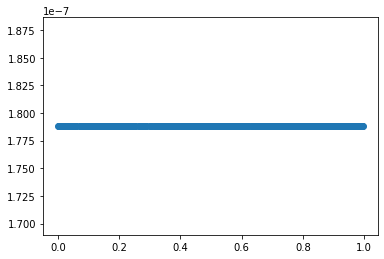

In [88]:
with torch.autograd.no_grad():
  solution1 = net1(Variable(torch.from_numpy(x_coll_1).float(), requires_grad=True).to(device))
  # solution2 = net2(Variable(torch.from_numpy(x_coll_2).float(), requires_grad=True).to(device))

plt.scatter(x_coll_1, solution1.numpy())
# plt.scatter(x_coll_2, solution2.numpy())

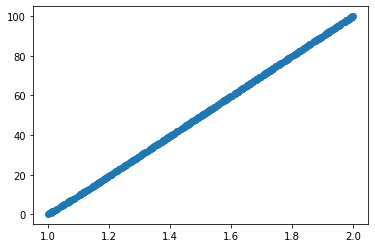

In [89]:
with torch.autograd.no_grad():
  # solution1 = net1(Variable(torch.from_numpy(x_coll_1).float(), requires_grad=True).to(device))
  solution2 = net2(Variable(torch.from_numpy(x_coll_2).float(), requires_grad=True).to(device))

# plt.scatter(x_coll_1, solution1.numpy())
plt.scatter(x_coll_2, solution2.numpy())

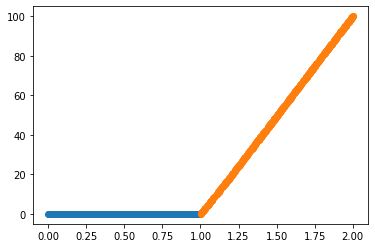

In [90]:
with torch.autograd.no_grad():
  solution1 = net1(Variable(torch.from_numpy(x_coll_1).float(), requires_grad=True).to(device))
  solution2 = net2(Variable(torch.from_numpy(x_coll_2).float(), requires_grad=True).to(device))

plt.scatter(x_coll_1, solution1.numpy())
plt.scatter(x_coll_2, solution2.numpy())

we can see from the above graph that the solution can be generated, but the problem is that all the points the range (0,1) get mapped to the temperature 0 just due to the fact that in the actual solution the slope of the first part is very less than the second part. 